## Imports

In [10]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.decorators import types
from pyccel.epyccel import epyccel

## Pure python function

In [48]:
def solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    cx = nu * (dt / dx**2)
    cy = nu * (dt / dy**2)
    #fill the update of u
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i] = u[i]
        for i in range(1, row - 1):
            for j in range(1, col - 1):
                u[i ,j] = un[i, j] + cx * (un[i+1, j] - 2 * un[i, j] + un[i-1, j]) \
                          + cy * (un[i, j+1] - 2 * un[i, j] + un[i, j-1])
        
    return 0

## Numba accelerator

In [49]:
@njit(fastmath = True)
def solve_2d_diff_numba(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', nu:'float'):
    row, col = u.shape
    
    ###Assign initial conditions
    # set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    
    cx = nu * (dt / dx**2)
    cy = nu * (dt / dy**2)
    #fill the update of u
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i] = u[i]
        for i in range(1, row - 1):
            for j in range(1, col - 1):
                u[i ,j] = un[i, j] + cx * (un[i+1, j] - 2 * un[i, j] + un[i-1, j]) \
                          + cy * (un[i, j+1] - 2 * un[i, j] + un[i, j-1])
        
    return 0

## Pyccel accelerator

In [50]:
def solve_2d_diff_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', nu:'float'):
    row, col = u.shape
    
    ##Assign initial conditions
    #set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    
    
    cx = nu * (dt / dx**2)
    cy = nu * (dt / dy**2)
    #fill the update of u
    for n in range(nt):
        for i in range(row):
            for j in range(col):
                un[i] = u[i]
        for i in range(1, row - 1):
            for j in range(1, col - 1):
                u[i ,j] = un[i, j] + cx * (un[i+1, j] - 2 * un[i, j] + un[i-1, j]) \
                          + cy * (un[i, j+1] - 2 * un[i, j] + un[i, j-1])
        
    return 0

## Inputs

/tmp/ipykernel_228101/2275955449.py:21: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


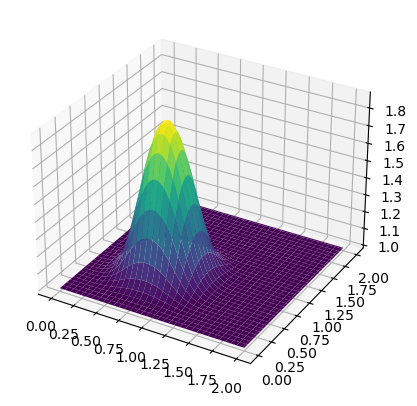

In [53]:
###variable declarations
nt = 100
nx = 101
ny = 101
nu = .05
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .25
dt = sigma * dx * dy / nu

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
un = np.ones((ny, nx))
    

solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u, cmap=cm.viridis)

## Call Funtions

### Pure function

In [54]:
%timeit solve_2d_diff_pure(u, un, nt, dt, dx, dy, nu)

3.77 s ± 246 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [43]:
%timeit solve_2d_diff_numba(u, un, nt, dt, dx, dy, nu)

42.9 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [46]:
solve_2d_diff_f90 = epyccel(solve_2d_diff_pyccel)

In [47]:
%timeit solve_2d_diff_f90(u, un, nt, dt, dx, dy, nu)

11.1 ms ± 55.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
